# Unsupervised Learning of Edge Orientation
* Synthetic Dataset from MuJoCo simulator
* Brian2

In [3]:
from IPython.display import Video

Video("../data/round_site.mp4")

# Sensor Simulation

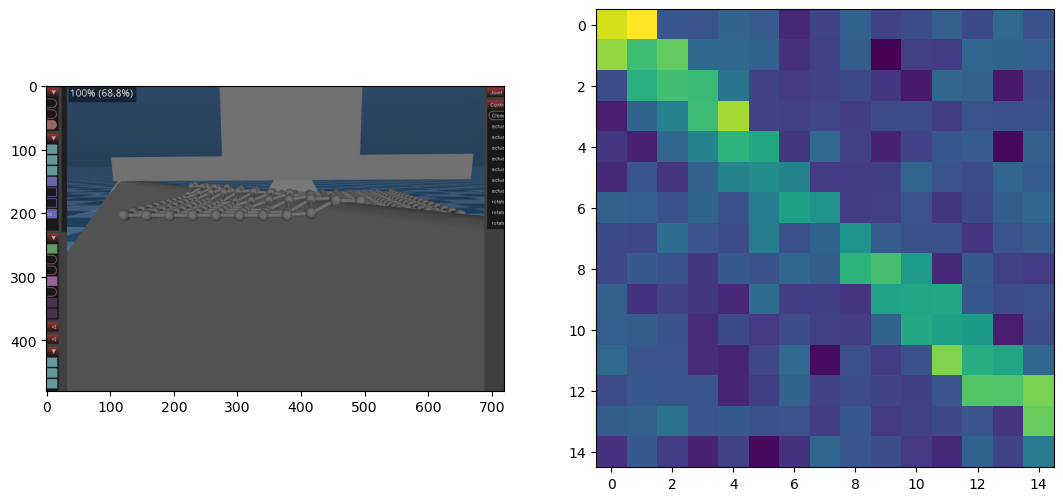

In [20]:
from matplotlib import pyplot as plt
from PIL import Image
from TouchDataset import TouchDataset

dataset = TouchDataset("../data/touch.pkl", flatten=False)
image = Image.open("../docs/softbody.png")
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
axs[0].imshow(image)
axs[1].imshow(dataset[5000][0])
plt.show()

# One-hidden Layer Spiking Network
1. Binary input layer
2. Random receptive field - 25 neurons
3. Output - 36 neurons

INFO:root:/home/fraaw/miniconda3/envs/tac3d/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -fPIC -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/fraaw/miniconda3/envs/tac3d/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -fPIC -c /tmp/tmpk2iu4fah.cpp -o tmp/tmpk2iu4fah.o -w
INFO:root:/home/fraaw/miniconda3/envs/tac3d/bin/x86_64-conda-linux-gnu-cc -Wno-unused-result -Wsign-compare -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -fPIC -O2 -isystem /home/fraaw/miniconda3/envs/tac3d/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/fraaw/miniconda3/envs/tac3d/include -DNDEBUG -D_FO

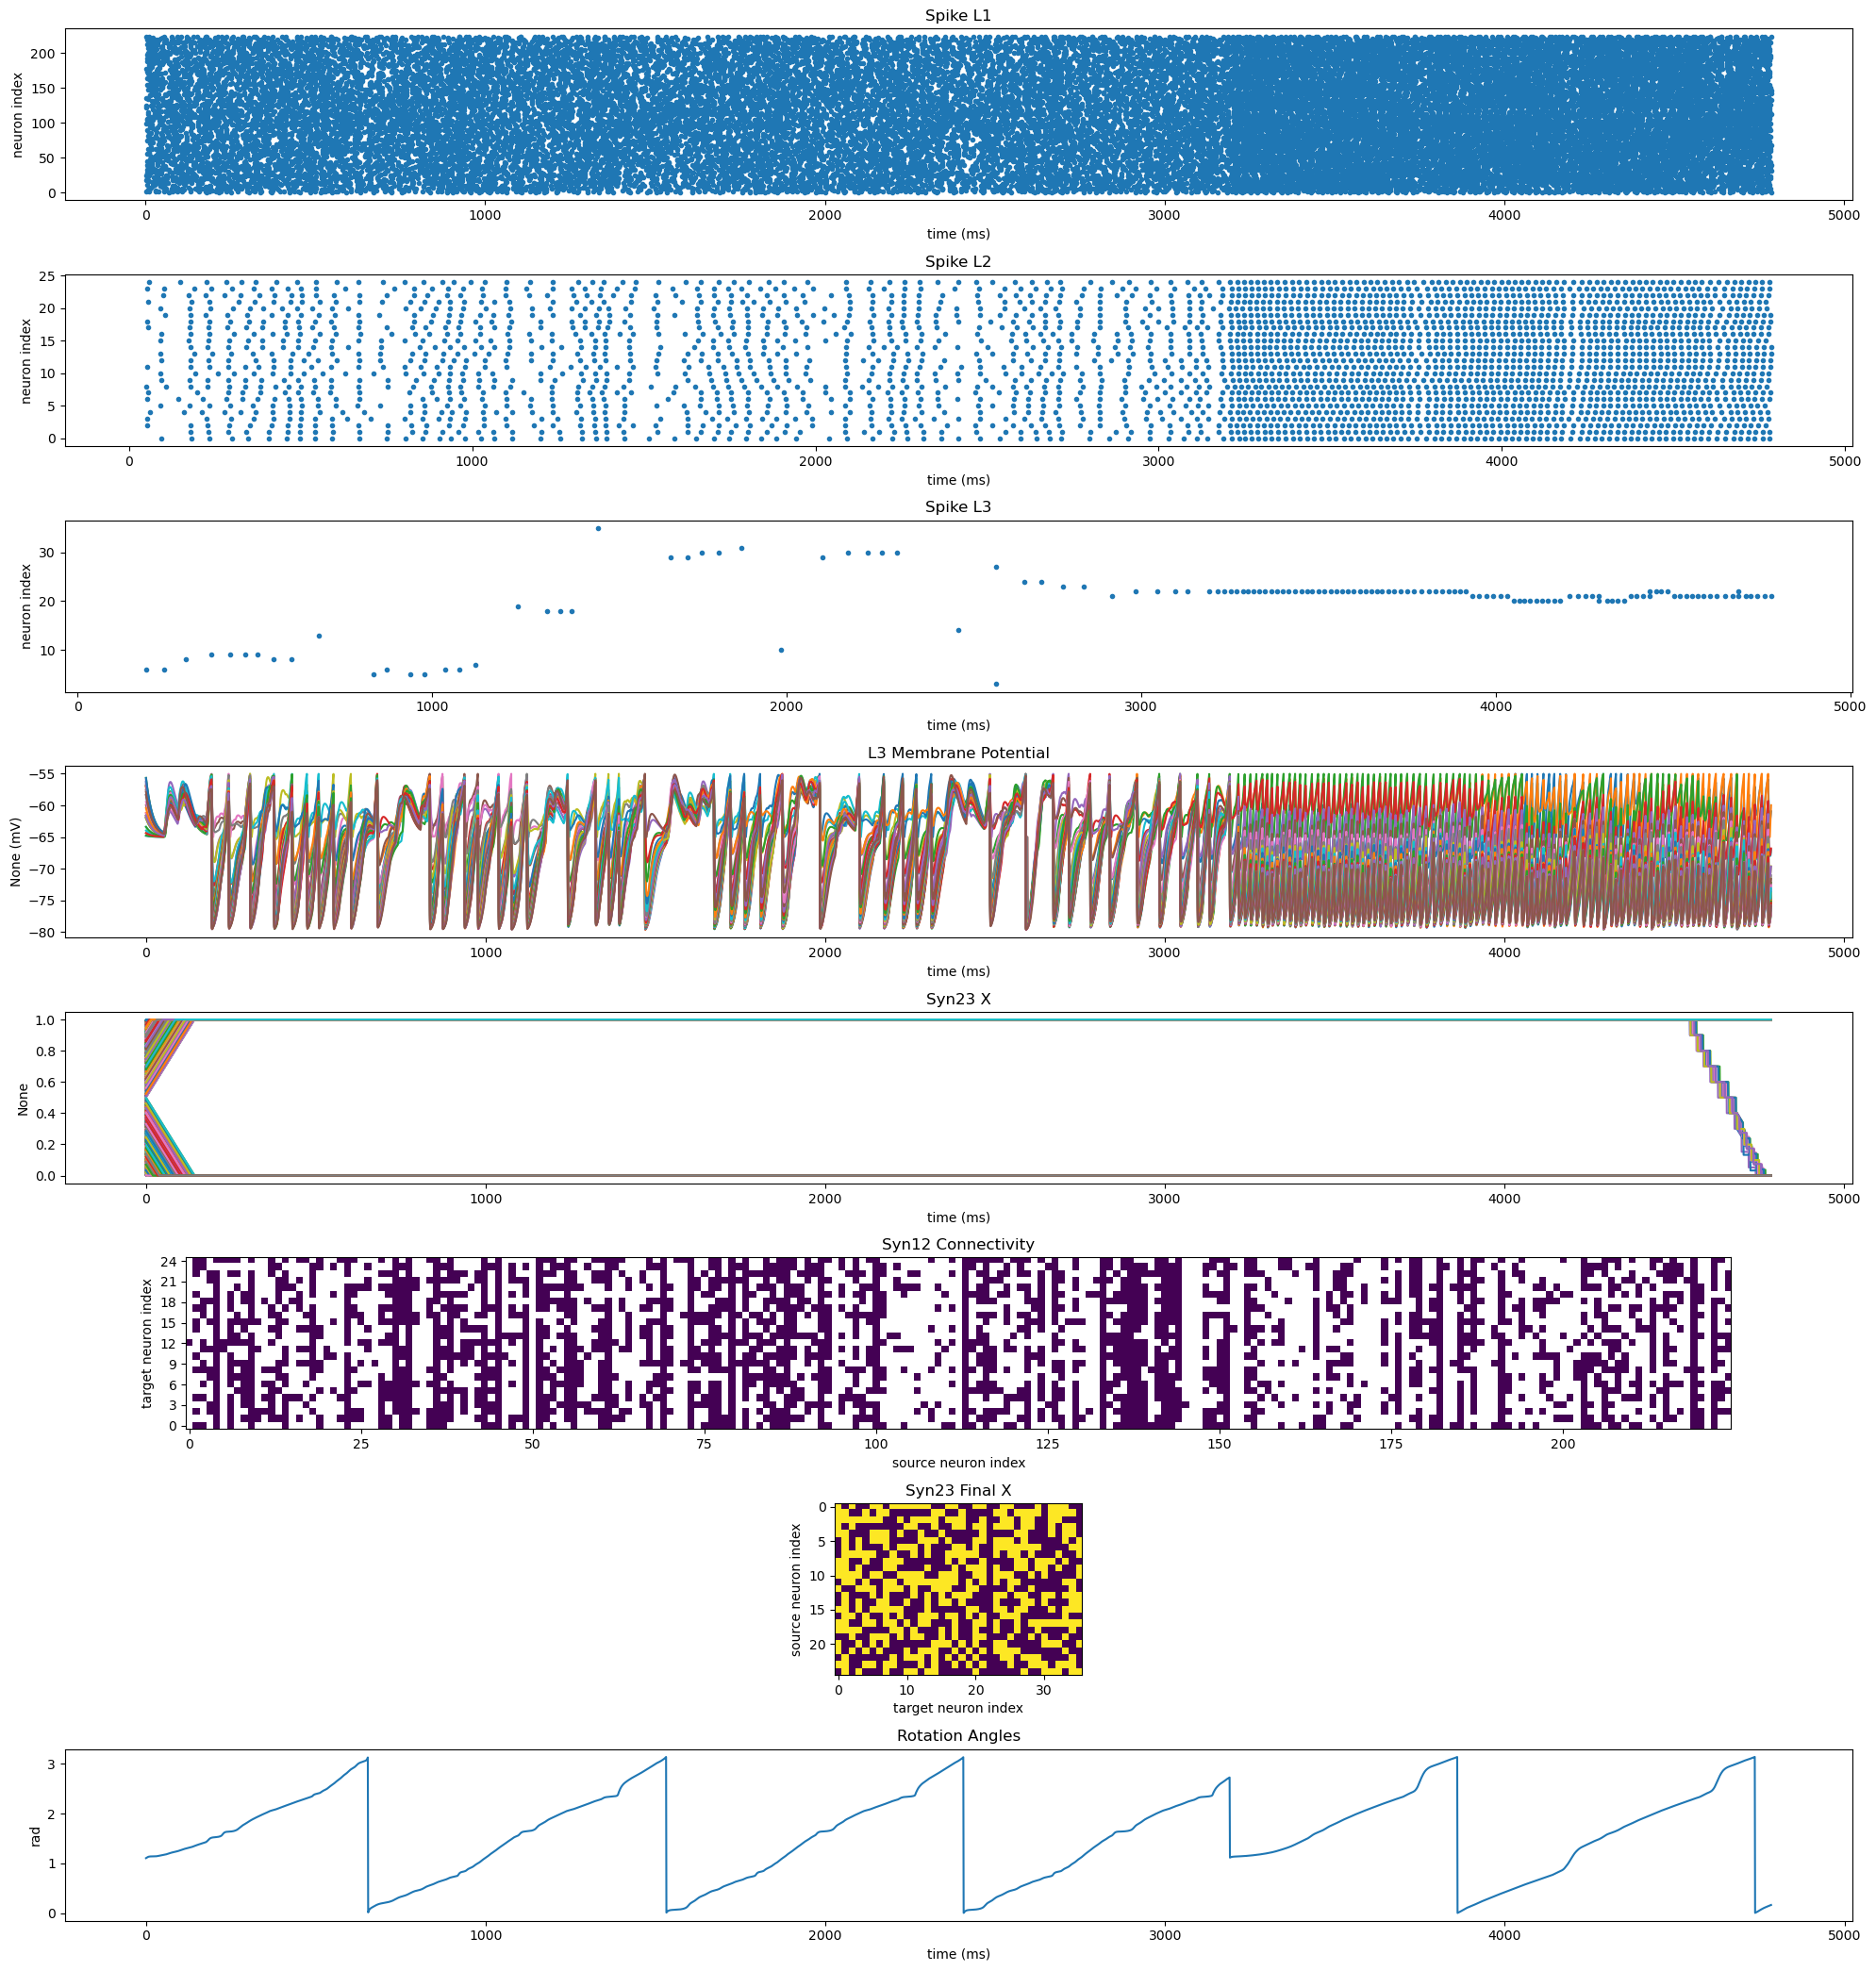

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
from brian2tools import brian_plot, plot_state
from TacNet import TacNet
from TouchDataset import TouchDataset

set_device("cpp_standalone")


def wrap2pi(angles):
    theta = np.array(angles)
    theta = theta.reshape(-1)
    n = np.floor(theta / np.pi)
    return theta - n * np.pi


# Prepare dataset
n = 1
dataset = TouchDataset("../data/touch.pkl", flatten=False)
X_train, y_train, X_test, y_test = dataset.split_set(ratio=0.5)
data, orientations = np.repeat(X_train, n, axis=0), np.repeat(y_train, n, axis=0)

# Convert values to spikes
dt = 1 * ms
length, height, width = data.shape
inputs = data.reshape(length, -1)
inputs[inputs > 0] = 1.0
I = TimedArray(inputs * 200 * pA, dt=dt)

# Prepare simulation
duration = I.values.shape[0] * dt
num_neurons = [height * width, 25, 36]
model = TacNet(num_neurons)
mons = model.run(I, duration)

# Plot results
fig, axs = plt.subplots(8, 1, figsize=(20, 21))
for i in range(3):
    axs[i].set_title("Spike L" + str(i + 1))
    brian_plot(mons["SpikeMonitor_L" + str(i + 1)], axes=axs[i])

axs[3].set_title("L3 Membrane Potential")
plot_state(mons["StateMonitor_L3"].t, mons["StateMonitor_L3"].v.T, axes=axs[3])
axs[4].set_title("Syn23 X")
plot_state(mons["StateMonitor_Syn23"].t, mons["StateMonitor_Syn23"].X.T, axes=axs[4])
axs[5].set_title("Syn12 Connectivity")
brian_plot(model.net["Syn12"], axes=axs[5])
axs[6].set_title("Syn23 Final X")
axs[6].set_xlabel("target neuron index")
axs[6].set_ylabel("source neuron index")
axs[6].imshow(model.net["Syn23"].X_[:].reshape((num_neurons[1], num_neurons[2])))
axs[7].plot(wrap2pi(orientations))
axs[7].set_title("Rotation Angles")
axs[7].set_xlabel("time (ms)")
axs[7].set_ylabel("rad")
plt.tight_layout()
plt.show()

# Generative MGGD Spatial Model
1. Stochastic representation: $\mathbf{x} = \tau \Sigma^{1/2} \mathbf{u}, \mathbf{u} \in \mathbb{R}^2$\
2. Scatter matrix $\Sigma = m \mathbf{M}$
3. Shape parameter $\beta$
4. $\tau^{2 \beta} \sim \Gamma(\frac{p}{2 \beta}, 2)$

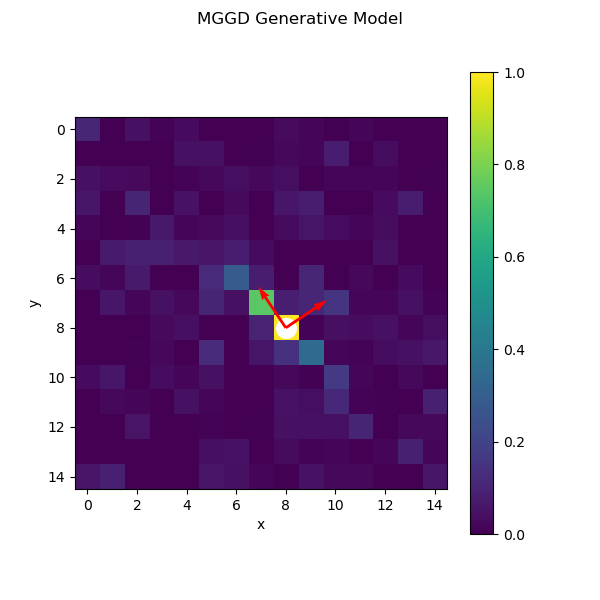

In [29]:
%matplotlib widget
from random import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from numpy import linalg as LA
from scipy.optimize import minimize


def genScatter(alpha=None, p=2):
    if alpha is None:
        alpha = random() * 2 * np.pi
    beta = alpha + np.pi / 2.0

    Q = np.array([[np.cos(alpha), np.cos(beta)], [np.sin(alpha), np.sin(beta)]])
    P = np.diag(np.random.rand(2))
    M = np.matmul(np.matmul(Q, P), LA.inv(Q))

    return M * p / M.trace()


def normalize2(xs, scope, dtype=int):
    xs = (xs - xs.min()) / (xs.max() - xs.min()) * (scope - 1)
    return np.clip(np.round(xs), 0, scope - 1).astype(dtype)


def generate_image(beta, m, M, p=2):
    nsamples = 1000
    # Stochastic process
    Sigma = np.sqrt(np.abs(m * M))
    phi = 2 * np.pi * np.random.random(nsamples) - np.pi
    u = np.array([np.cos(phi), np.sin(phi)])
    tau = np.power(np.random.gamma(0.5 * p / beta, 2, nsamples), 0.5 / beta)
    x = tau * np.matmul(Sigma, u)

    x = normalize2(x, 15)

    im = np.zeros((15, 15), dtype=int)
    for ns in np.arange(nsamples):
        im[x[0, ns], x[1, ns]] += 1
    noise = np.random.normal(np.mean(im), 0.5 * np.sqrt(np.var(im)), im.shape)
    im += np.round(noise).astype(int)
    im[im < 0] = 0
    im = (im - im.min()) / (im.max() - im.min())

    X, Y = np.meshgrid(np.linspace(1, 16, 15), np.linspace(1, 16, 15))
    center = (
        np.round(np.sum(X * im / np.sum(im))) - 1,
        np.round(np.sum(Y * im / np.sum(im))) - 1,
    )
    w, v = LA.eig(M)
    X = [center[1], center[1]]
    Y = [center[0], center[0]]
    U = v[0, :]
    V = v[1, :]

    return im, center, v


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
im, center, v = generate_image(0.5, 10, genScatter())
image = ax.imshow(im)
scatter = ax.scatter(center[1], center[0], s=200, c="w")
quiver = ax.quiver(
    [center[1], center[1]],
    [center[0], center[0]],
    v[0, :],
    v[1, :],
    color="r",
    scale_units="xy",
    scale=0.5,
)
fig.colorbar(image, ax=ax)


def init():
    im, center, v = generate_image(
        np.random.rand(1) * 6, np.random.rand(1) * 15, genScatter()
    )
    image.set_data(im)
    scatter.set_offsets(center)
    quiver.set_offsets(np.asarray([center, center]))
    quiver.set_UVC(v[0, :], v[1, :])

    return image, dot, quiver


def update(frame):
    beta = np.random.rand(1) * 6
    im, center, v = generate_image(beta, np.random.rand(1) * 15, genScatter())
    image.set_data(im)
    scatter.set_offsets(center)
    quiver.set_offsets(np.asarray([center, center]))
    quiver.set_UVC(v[0, :], v[1, :])
    ax.set_title(r"$\beta = $ %.1f" % beta[0])

    return image, dot, quiver


ani = FuncAnimation(fig, update, frames=100, interval=400, init_func=init, blit=True)

plt.suptitle("MGGD Generative Model")
plt.show()

# MGG Spatial Model Parameter Estimation with SNN in Nengo

In [10]:
import nengo
import numpy as np
from scipy.optimize import minimize


d = 2

class MultiVarGenGaussian:
    def __init__(self, mu, Sigma, beta):
        self.mu = mu
        self.Sigma = Sigma
        self.beta = beta

    def pdf(self, X):
        d = X.shape[1]
        diff = X - self.mu
        exponent = -0.5 * np.sum(
            np.power(np.dot(diff, np.linalg.inv(self.Sigma)), 2), axis=1
        )
        exponent = np.power(1 + exponent / self.beta, -(self.beta + d) / 2)
        return np.prod(exponent)

    def log_likelihood(self, X):
        return np.sum(np.log(self.pdf(X)))


def estimate_params(X):
    n, d = X.shape
    mu0 = np.mean(X, axis=0)
    Sigma0 = np.cov(X.T)
    beta0 = 1.0
    model = MultiVarGenGaussian(mu0, Sigma0, beta0)
    res = minimize(lambda beta: -model.log_likelihood(X), beta0, method="BFGS")
    beta_hat = res.x[0]
    model.beta = beta_hat
    return model


# Define the network
with nengo.Network() as net:
    # Input layer
    inp = nengo.Node([0] * d)

    # Ensemble for processing the input
    ens = nengo.Ensemble(n_neurons=100, dimensions=d)

    # Connect the input layer to the ensemble
    # Apply STDP to the connection
    voja = nengo.Voja(learning_rate=5e-2, post_synapse=None)
    conn = nengo.Connection(inp, ens, learning_rule_type=voja)

    # Output layer
    out = nengo.Node(size_in=d)

    # Connect the ensemble to the output layer
    nengo.Connection(ens, out)

# Simulate the network
with nengo.Simulator(net) as sim:
    sim.run(10)

X = (
    np.random.randn(100, 2) + 1
)  # generate 100 samples from a 2-dimensional normal distribution
model = estimate_params(X)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/tmp/ipykernel_875/3616474060.py:20: RuntimeWarning: invalid value encountered in power
  exponent = np.power(1 + exponent / self.beta, -(self.beta + d) / 2)
